# MNIST dataset handling
---

In this notebook we will deploy a custom `dataset` class which will be able to:
- import the MNIST dataset from a **url**
- **read** the MNIST dataset and **load** it in a `torch.tensor`
- **save** the dataset in `.pt` format to be easily accessible within the `PyTorch` environment
- provide a method to create the dataset **splits**, according to some proportions
- provide a method to perform some **preprocessing** operations

We will procede as follows:
- file decoding procedure
    - analisys of the MNIST dataset format (info taken from this [source](http://yann.lecun.com/exdb/mnist/))
    - reading the file and retrieving the data dimensions and type
    - loading the data into a `torch.tensor`
- `dataset` class construction
    - `__init__`
    - `create_splits`

In [1]:
import torch
import struct       # to unpack binary data https://docs.python.org/3/library/struct.html

## File decoding procedure
### MNIST Dataset format


The **IDX file format** is a simple format for vectors and multidimensional matrices of various numerical types.
The basic format is

```
magic number
size in dimension 0
size in dimension 1
size in dimension 2
.....
size in dimension N
data
```
    
The magic number is an integer (MSB first). The first 2 bytes are always 0.

The third byte codes the type of the data:
- 0x08: unsigned byte
- 0x09: signed byte
- 0x0B: short (2 bytes)
- 0x0C: int (4 bytes)
- 0x0D: float (4 bytes)
- 0x0E: double (8 bytes)

The 4-th byte codes the number of dimensions of the vector/matrix: 1 for vectors, 2 for matrices....

The sizes in each dimension are 4-byte integers (MSB first, high endian, like in most non-Intel processors).

The data is stored like in a C array, i.e. the index in the last dimension changes the fastest.

### Reading the file and retrieving the data dimensions and type

Taking into account the MNIST dataset format provided in the reference at the beginning of this notebook

In [2]:
with open('train-images-idx3-ubyte', 'rb') as f:    # open the file for reading in binary mode 'rb'                         
    m_numb_32bit = f.read(4)    # magic number

At the moment, all the retrieved informations are in the form of bytes. 

The `f.read(4)` function call, reads 4 bytes (32 bits) at a time from the original file, then it proceeds to the next 4. And so on.

In the above variable, the information are stored in exadecimal binary format.

We can then retrieve the bytes composing the magic number and store them in a list (`m_numb_list`) in which the indices are as follows:
 - \[0\]: 0
 - \[1\]: 0
 - \[2\]: encoding number for the type of the data
 - \[3\]: number of dimensions


In [3]:
m_numb_list = [byte for byte in m_numb_32bit]
print('\nm_numb_list: ',m_numb_list)


m_numb_list:  [0, 0, 8, 3]


As anticipated, the bytes of the magic number gives us some information. In particular:
- the third byte defines the type of the data (in this case it is `0x08` which encoded for `unsigned byte`)
- the fourth byte defines the number of dimensions (in this case `3`, so we have a cube)

We can then read the following bytes to retrieve some other information about the dimensions of the data:
- d_list_32bit\[0\]: size in dimension 0
- d_list_32bit\[1\]: size in dimension 1
- d_list_32bit\[2\]: size in dimension 2
- ...
- d_list_32bit\[N\]: size in dimension N

**NOTE**: here we are considering the `train-images-idx3-ubyte` file, which is referred to the training images. For the other files, more or less dimensions might be available.

In [4]:
with open('train-images-idx3-ubyte', 'rb') as f:    # open the file for reading in binary mode 'rb'       
    f.read(4)                   # discard the first 4 bytes (magic number)
    d_list_32bit = [f.read(4) for _ in range(m_numb_list[3])]

print('d_list_32bit:', d_list_32bit)

d_list_32bit: [b'\x00\x00\xea`', b'\x00\x00\x00\x1c', b'\x00\x00\x00\x1c']


We obtain a list of three elements, which represents the the number of data in each dimension.

We use the `struct` module from Python in order to convert the byte format into the decimal one.
In order to do so, we use the big-endian format `">"` along with the type/size of bytes that we want to unpack at a time: 
- for the informations bytes (which corresponds to the N + 1 first 4-bytes (32 bits) elements of the file, being N the number of dimensions) we use the `">I"` format (i.e. big-endian 4-bytes int)
- for the actual data we will rely on the third byte of the magic number.

In [5]:
dimensions = [struct.unpack('>I', dimension)[0] for dimension in d_list_32bit]
print('dimensions:', dimensions)


dimensions: [60000, 28, 28]


At this point we can wrap all the lines of code written so far into a prototype function which will read an input IDX file and return the list of its dimensions.

In [6]:
def read_idx_file(file_path: str) -> list:
    
    # open the file for reading in binary mode 'rb'
    with open(file_path, 'rb') as f:     
        # magic number list   
        m_numb_list = [byte for byte in f.read(4)] 
        # dimensions list  
        d_list_32bit = [f.read(4) for _ in range(m_numb_list[3])]
        # unpack data
        dimensions = [struct.unpack('>I', dimension)[0] for dimension in d_list_32bit]

        return dimensions

In [7]:
print(read_idx_file(r'train-images-idx3-ubyte'))
print(read_idx_file(r'train-labels-idx1-ubyte'))
print(read_idx_file(r't10k-images-idx3-ubyte'))
print(read_idx_file(r't10k-labels-idx1-ubyte'))

[60000, 28, 28]
[60000]
[10000, 28, 28]
[10000]


### Loading the data into a `torch.tensor`

Now we can focus on the part of the _file decoding procedure_: retrieving the data and loading it into a `torch.tensor`.

It will be useful to report the encoding strings here and to create an ad-hoc dictionary to handle it.
- 0x08: unsigned byte
- 0x09: signed byte
- 0x0B: short (2 bytes)
- 0x0C: int (4 bytes)
- 0x0D: float (4 bytes)
- 0x0E: double (8 bytes)

The encoding dictionary contains, for each exadecimal byte, the corresponding format, the standard size (used by `f.read(...)` in order to match the size defined by the format) and the PyTorch type, to be used when we will load the dataset into a `torch.tensor`.

The format that we will use to unpack the data is reported below.


In [8]:
encoding = {
      b'\x08':['B',1,torch.uint8]
    , b'\x09':['b',1,torch.int8]
    , b'\x0B':['h',2,torch.short]
    , b'\x0C':['i',4,torch.int32]
    , b'\x0D':['f',4,torch.float32]
    , b'\x0E':['d',8,torch.float64]
    }

e_format = ">" + encoding[m_numb_list[2].to_bytes(1, byteorder='big')][0]
n_bytes = encoding[m_numb_list[2].to_bytes(1, byteorder='big')][1]
d_type = encoding[m_numb_list[2].to_bytes(1, byteorder='big')][2]

Now that we have the dimensions and the encoding format we can procede retrieving the actual data.
To do so, we will consider again the case of the training images dataset trying to generalize it as much as possible, in order to exploit the code for the other files too.

In [9]:
import time

start = time.time()

with open('train-images-idx3-ubyte', 'rb') as f:    # open the file for reading in binary mode 'rb'       
    f.read(16)    # discard the first 16 bytes (magic number + informations)
    
    # reading all the bytes of the file progressively and store them in a torch.tensor accordingly to the dimensions
    dataset = torch.tensor([[[struct.unpack(e_format, f.read(n_bytes))[0] 
                                for _ in range(dimensions[2])] 
                                for _ in range(dimensions[1])] 
                                for _ in range(dimensions[0])]
                            , dtype=d_type)

end = time.time()
print("Loading time: {:2f}".format(end-start))


Loading time: 18.926226


The bigger dataset, which in this case is the one of the training images, takes approximately 20s to be read and loaded into a `torch.tensor`.

We can update the previously defined function, changing a bit its name into `read_idx_file_to_tensor()` and adapting the tensor inizialization taking into account the possibility of having different dimensions

In [10]:
def read_idx_file_to_tensor(file_path: str) -> torch.tensor:
    
    # open the file for reading in binary mode 'rb'
    with open(file_path, 'rb') as f:     
        # magic number list   
        m_numb_list = [byte for byte in f.read(4)] 
        # dimensions list  
        d_list_32bit = [f.read(4) for _ in range(m_numb_list[3])]
        dimensions = [struct.unpack('>I', dimension)[0] for dimension in d_list_32bit]
        
        encoding = {
                      b'\x08':['B',1,torch.uint8]
                    , b'\x09':['b',1,torch.int8]
                    , b'\x0B':['h',2,torch.short]
                    , b'\x0C':['i',4,torch.int32]
                    , b'\x0D':['f',4,torch.float32]
                    , b'\x0E':['d',8,torch.float64]
                    }

        e_format = ">" + encoding[m_numb_list[2].to_bytes(1, byteorder='big')][0]
        n_bytes = encoding[m_numb_list[2].to_bytes(1, byteorder='big')][1]
        d_type = encoding[m_numb_list[2].to_bytes(1, byteorder='big')][2]


        if len(dimensions) == 3:    # images
           
            print('Loading {} ...'.format(file_path))
            
            dataset = torch.tensor(
                [
                    [
                        [struct.unpack(e_format, f.read(n_bytes))[0] 
                        for _ in range(dimensions[2])] 
                    for _ in range(dimensions[1])] 
                for _ in range(dimensions[0])]
                , dtype=d_type
            )

            print('{} loaded!'.format(file_path))
        

        elif len(dimensions) == 1:  # labels
        
            print('Loading {} ...'.format(file_path))

            dataset = torch.tensor(
                [struct.unpack(e_format, f.read(n_bytes))[0]
                for _ in range(dimensions[0])]
                , dtype=d_type
            )

            print('{} loaded!'.format(file_path))
        

        else:   # wrong dimensions
            raise ValueError("Invalid dimensions in the IDX file!")

        
        return dataset

Having created this main function, we are able to call it, passing the paths to the files. One possible method consists in calling the training images and the training labels inside a tuple called `training_set` which will then be just a tuple of `torch.tensor`s. The same will be done for the `test_set` tuple, as shown below.

In [11]:
training_set = (
    read_idx_file_to_tensor(r'train-images-idx3-ubyte')
    , read_idx_file_to_tensor(r'train-labels-idx1-ubyte')
)

test_set = (
    read_idx_file_to_tensor(r't10k-images-idx3-ubyte')
    , read_idx_file_to_tensor(r't10k-labels-idx1-ubyte')

)

Loading train-images-idx3-ubyte ...
train-images-idx3-ubyte loaded!
Loading train-labels-idx1-ubyte ...
train-labels-idx1-ubyte loaded!
Loading t10k-images-idx3-ubyte ...
t10k-images-idx3-ubyte loaded!
Loading t10k-labels-idx1-ubyte ...
t10k-labels-idx1-ubyte loaded!


We can check the correctness of this function by printing the first 10 image-label pairs of each dataset.

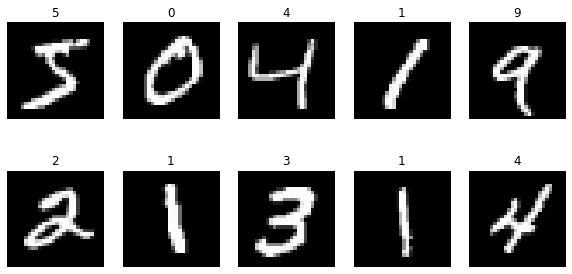

In [12]:
import matplotlib.pyplot as plt

n_images = 10

fig = plt.figure(figsize=(10,5))
for i in range(n_images):
    image = training_set[0][i]
    label = training_set[1][i].item()
    sp = fig.add_subplot(2, 5, i+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()


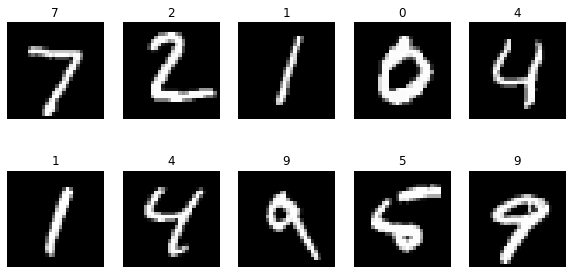

In [13]:
n_images = 10

fig = plt.figure(figsize=(10,5))
for i in range(n_images):
    image = test_set[0][i]
    label = test_set[1][i].item()
    sp = fig.add_subplot(2, 5, i+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()